# Imports and modules

In [87]:
import os
import requests
import pandas as pd
import time 
import numpy as np
import pytz
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import geopandas as gpd

from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, classification_report
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_selection import r_regression
from sklearn.neighbors import KNeighborsClassifier
from shapely.geometry import Point
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Extract from CSV and Preprocessing

## Function to extract data from CSV

In [88]:
def get_data(path, file_names):
    tables=[]
    for file_name in file_names:
        table = pd.read_csv(f'../{path}/{file_name}.csv')
        table['type']=f'{file_name}'
        tables.append(table)
    return pd.concat(tables)

path='data/raw_data'
file_names = ['trawlers', 'drifting_longlines', 'fixed_gear', 'pole_and_line', 'purse_seines', 'trollers', 'unknown']
df = get_data(path, file_names)
df.head(2)

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source,type
0,1.252340e+12,1.325376e+09,0.0,0.0,0.0,153.0,52.458649,4.581200,-1.0,gfw,trawlers
1,1.252340e+12,1.325378e+09,0.0,0.0,0.0,153.0,52.458668,4.581167,-1.0,gfw,trawlers


In [89]:
df['mmsi'].nunique()

354

## Remove unknown (-1 in is_fishing column)

In [90]:
df = df.loc[df['is_fishing'] > -1]
df['is_fishing'].value_counts()

is_fishing
0.000000    295979
1.000000    247498
0.666667      4806
0.333333      4096
0.750000       752
0.250000       670
0.800000        33
0.166667        12
0.400000         9
Name: count, dtype: int64

## Converting is_fishing to Binary (0 or 1)

In [91]:
df_fishing = df.copy()

# round the decimals so that number becomes 0 or 1
df_fishing.loc[:, ('is_fishing')] = round(df_fishing.loc[:, ('is_fishing')])

# check the unique values
df_fishing['is_fishing'].value_counts()

is_fishing
0.0    300766
1.0    253089
Name: count, dtype: int64

## OHE 'type'

In [92]:
# Instantiate the OneHotEncoder
ohe = OneHotEncoder(sparse_output =False)

# Fit encoder
ohe.fit(df[['type']])

# Transform the current "Alley" column
df[ohe.get_feature_names_out()] = ohe.transform(df[['type']])

# Drop the column "Alley" which has been encoded
df.drop(columns = ["type", "source"], inplace = True)

# Date Engineering

## Converting timestamp to datetime format

In [93]:
df_fishing['timestamp'] = pd.to_datetime(df_fishing['timestamp'], unit='s')
df_fishing.rename(columns={"timestamp": "date"}, inplace=True)
df_fishing['month'] = df_fishing['date'].dt.month
df_fishing['day_of_week'] = df_fishing['date'].dt.day_of_week
df_fishing.head(2)

,mmsi,date,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source,type,month,day_of_week
60646,1.252340e+12,2015-01-01 05:08:23,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,gfw,trawlers,1,3
60647,1.252340e+12,2015-01-01 05:20:34,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,gfw,trawlers,1,3


## Using Angular distance for the days of the week

In [94]:
df_fishing['day_of_week_sin'] = np.sin(df_fishing['day_of_week'] * (2 * np.pi / 7))
df_fishing['day_of_week_cos'] = np.cos(df_fishing['day_of_week'] * (2 * np.pi / 7))

## Encoding dates

In [95]:
# Instantiate the OneHotEncoder
ohe = OneHotEncoder(sparse_output =False)

# Fit encoder
ohe.fit(df_fishing[['day_of_week']])

# Transform the current "day_of_week" column
df_fishing[ohe.get_feature_names_out()] = ohe.transform(df_fishing[['day_of_week']])

# Drop the column "day_of_week" which has been encoded
df_fishing.drop(columns = ["day_of_week"], inplace = True)

In [96]:
# Instantiate the OneHotEncoder
ohe = OneHotEncoder(sparse_output =False)

# Fit encoder
ohe.fit(df_fishing[['month']])

# Transform the current "month" column
df_fishing[ohe.get_feature_names_out()] = ohe.transform(df_fishing[['month']])

# Drop the column "month" which has been encoded
df_fishing.drop(columns = ["month"], inplace = True)

In [97]:
# Calculate the value counts of 'mmsi'
mmsi_counts = df_fishing['mmsi'].value_counts()

# Create a boolean mask for filtering mmsi values with counts less than or equal to 20
mask = mmsi_counts > 10

# Get the mmsi values that meet the condition
selected_mmsi = mmsi_counts[mask].index

# Use the isin() method to filter the DataFrame based on selected_mmsi
filtered_fishing_df = df_fishing[df_fishing['mmsi'].isin(selected_mmsi)]
filtered_fishing_df.nunique()

mmsi                      299
date                   545942
distance_from_shore     79307
distance_from_port      95720
speed                     240
course                   3602
lat                    363346
lon                    372710
is_fishing                  2
source                      6
type                        7
day_of_week_sin             7
day_of_week_cos             7
day_of_week_0               2
day_of_week_1               2
day_of_week_2               2
day_of_week_3               2
day_of_week_4               2
day_of_week_5               2
day_of_week_6               2
month_1                     2
month_2                     2
month_3                     2
month_4                     2
month_5                     2
month_6                     2
month_7                     2
month_8                     2
month_9                     2
month_10                    2
month_11                    2
month_12                    2
dtype: int64

## Defining X features and y target

In [98]:
# Dropping rows with NAN values
df_fishing_clean = filtered_fishing_df.dropna()
df_fishing_clean.isna().sum()

mmsi                   0
date                   0
distance_from_shore    0
distance_from_port     0
speed                  0
course                 0
lat                    0
lon                    0
is_fishing             0
source                 0
type                   0
day_of_week_sin        0
day_of_week_cos        0
day_of_week_0          0
day_of_week_1          0
day_of_week_2          0
day_of_week_3          0
day_of_week_4          0
day_of_week_5          0
day_of_week_6          0
month_1                0
month_2                0
month_3                0
month_4                0
month_5                0
month_6                0
month_7                0
month_8                0
month_9                0
month_10               0
month_11               0
month_12               0
dtype: int64

# Defining X - Features and y - Target

In [102]:
# Defining X - the features and Y - the target
X = df_fishing_clean.drop(columns=['mmsi','date', 'is_fishing','source', 'type'])
y = df_fishing_clean['is_fishing']
X.shape, y.shape

((553702, 27), (553702,))

# Correlation

## Pearson correlation

In [103]:
corr = r_regression(X, y)
col_names = list(X.columns)
df_corr = pd.DataFrame()
df_corr ['feature'] = col_names
df_corr ['corr'] = corr
df_corr ['abs_corr'] = np.abs(df_corr ['corr'])
numbers = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.10, 0.20]
no_len = []

for num in numbers:
    no_len.append(len(df_corr[df_corr['abs_corr']>num]))

print(no_len)

[27, 18, 12, 12, 12, 10, 4, 2]


In [104]:
df_clean = df_corr[df_corr['abs_corr']>0.02]
names = df_clean['feature'].values.tolist()

In [105]:
X18 = df_fishing_clean[names]
y18 = df_fishing_clean['is_fishing']
X18.shape, y18.shape

((553702, 12), (553702,))

## Heatmap

In [108]:
data = df_fishing_clean.drop(columns=['mmsi','date', 'is_fishing','source', 'type'])

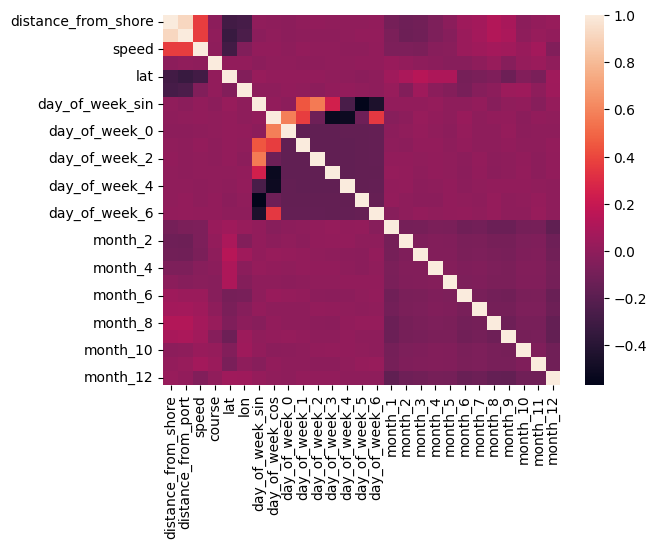

In [109]:
# plotting correlation heatmap
dataplot=sns.heatmap(data.corr())
  
# displaying heatmap
plt.show()

# Split between train set and test set

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)

In [112]:
X_test_with_MMSI = X_test.merge(df['mmsi'], left_index=True, right_index=True)

In [113]:
output_folder = '../data/'
output_file = 'X_test.csv'

# Construct the full path
output_path = f'{output_folder}/{output_file}'

# Save the DataFrame to the specified path
X_test_with_MMSI.to_csv(output_path, index=False)

In [ ]:
X18_train, X18_test, y_train, y_test = train_test_split(X18, y, test_size=0.3, random_state=88)

## Standard Scaler

In [ ]:
scale = StandardScaler()

# Logistic Regresssion

In [ ]:
logistic_pipeline = make_pipeline(scale, LogisticRegression(max_iter=1000))
logistic_pipeline

In [ ]:
# Train Pipeline
logistic_pipeline.fit(X_train,y_train)

# Make predictions
y_pred = logistic_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f} Precision:{precision:.2f}")

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
cv_lr_results = cross_validate(logistic_pipeline,
                            X_test, 
                            y_test, 
                            cv=5,
                            scoring =['accuracy'])
cv_lr_results['test_accuracy'].mean()

# KNN Classifier

In [ ]:
knn_pipeline = make_pipeline(scale, KNeighborsClassifier(n_neighbors=3))
knn_pipeline

In [ ]:
# Train Pipeline
knn_pipeline.fit(X_train,y_train)
y_pred = knn_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f} Precision:{precision:.2f}")

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
cv_knn_results = cross_validate(knn_pipeline,
                            X_test, 
                            y_test, 
                            cv=5,
                            scoring =['accuracy'])
cv_knn_results['test_accuracy'].mean()

# Random forest

In [ ]:
rff_pipeline = make_pipeline(scale, RandomForestClassifier())
rff_pipeline

In [ ]:
# Train Pipeline
rff_pipeline.fit(X_train,y_train)
y_pred = rff_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f} Precision:{precision:.2f}")

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
cv_results = cross_validate(rff_pipeline,
                            X_test, 
                            y_test, 
                            cv=5,
                            scoring =['accuracy'])
cv_results['test_accuracy'].mean()

In [ ]:
# Train Pipeline
rff_pipeline.fit(X18_train,y_train)
y18_pred = rff_pipeline.predict(X18_test)
accuracy = accuracy_score(y_test, y18_pred)
precision = precision_score(y_test, y18_pred)
print(f"Accuracy: {accuracy:.2f} Precision:{precision:.2f}")

In [ ]:
print(classification_report(y_test, y18_pred))

In [ ]:
cv_results25 = cross_validate(rff_pipeline,
                            X18_test, 
                            y_test, 
                            cv=5,
                            scoring =['accuracy'])
cv_results['test_accuracy'].mean()

# Export to CSV for quick access

In [ ]:
output_folder = '../data/preprocessed'
output_file = 'preproc.csv'

# Construct the full path
output_path = f'{output_folder}/{output_file}'

# Save the DataFrame to the specified path
df_fishing.to_csv(output_path, index=False)

# Map data on world map with geopandas

In [ ]:
geometry = [Point(xy) for xy in zip(df_fishing['lon'], df_fishing['lat'])]
crs = {'init':'epsg:4326'}
geo_df = gpd.GeoDataFrame(df_fishing, #specify our data
                          crs=crs, #specify our coordinate reference system
                          geometry=geometry) #specify the geometry list we created
geo_df.head()

## Mapping one boat

In [ ]:
boat = geo_df._get_value(60649, 'mmsi')
one_boat = geo_df.loc[geo_df['mmsi']== boat]

In [ ]:
# Getting world map data from geo pandas
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(16, 10))
worldmap.plot(color="lightgrey", ax=ax)

# Plotting Longitudes and Latitudes of one boat
x = one_boat['lon']
y = one_boat['lat']
plt.scatter(x, y, cmap='autumn')
plt.line(x, y)

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## Mapping all boats

In [ ]:
# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(16, 10))
worldmap.plot(color="lightgrey", ax=ax)

# Plotting Longitudes and Latitudes of one boat
x = geo_df['lon']
y = geo_df['lat']
boats = geo_df['mmsi']
plt.scatter(x, y, c=boats, cmap='autumn')

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [ ]:
df_fishing_clean.shape

In [ ]:
df_fishing_clean['is_fishing'].value_counts()

In [ ]:
grouped = df_fishing_clean.groupby('mmsi')

In [ ]:
grouped['is_fishing'].value_counts()